In [1]:
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent.parent
sys.path.append(str(parent_dir))
from instruments import *
from physical_models import *
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    "lines.linewidth": 3,
})


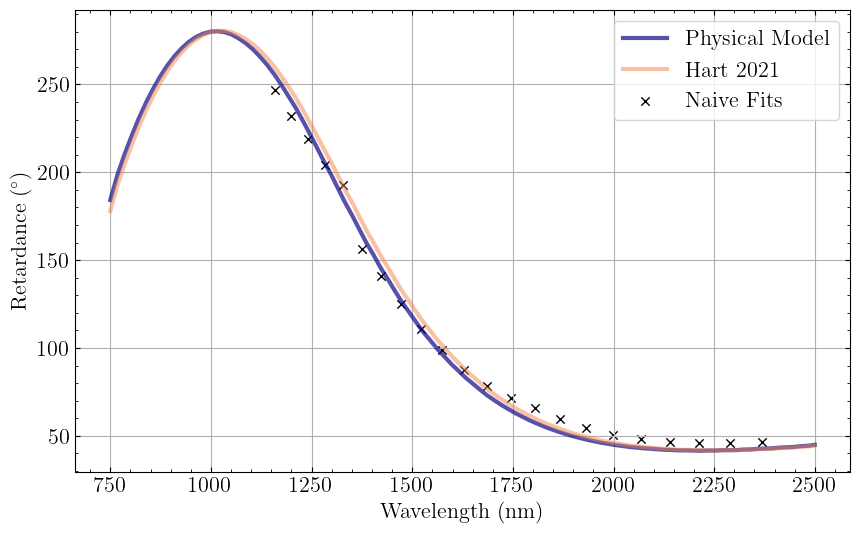

In [3]:
# Use results from minimization to make imr plot

wsio2, wmgf2, d = [1.66725, 1.30159, 259.1467]
hart = [1.623,1.268,262.56]
#nodegen = [1.656, 1.293, 257.0]
wavelengths = np.linspace(750,2500,100)
json_dir = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dics_justrets')
params,fig,ax = plot_config_dict_vs_wavelength('image_rotator', 'phi',json_dir, title= '', axtitle='Retardance ($^{\circ}$)')
cmap = plt.get_cmap('plasma')
ax.plot(wavelengths,np.rad2deg(IMR_retardance(wavelengths,d)), color=cmap(0.0), alpha = 0.7, label = 'Physical Model')
#ax.plot(wavelengths,np.rad2deg(IMR_retardance(wavelengths,nodegen[2])), color=cmap(0.3), alpha = 0.5, label = 'Removed Degeneracy')
ax.plot(wavelengths,np.rad2deg(IMR_retardance(wavelengths,hart[2])), color=cmap(0.7), alpha = 0.5, label = 'Hart 2021')
ax.scatter([], [], marker='x',color='black' ,label='Naive Fits', linewidths=1)
ax.legend()
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
plt.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/imr_ret_vs_wavelength_minimize.png', bbox_inches='tight', dpi=600)


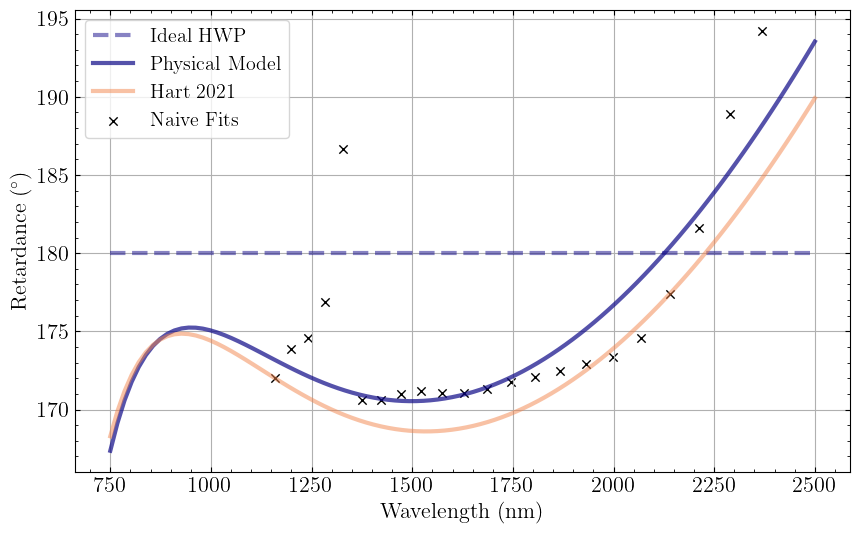

In [4]:
# now do hwp retardance

params,fig,ax = plot_config_dict_vs_wavelength('hwp', 'phi',json_dir, title= '', axtitle='Retardance ($^{\circ}$)')
ax.plot(wavelengths, np.repeat(180, 100), color=cmap(1), alpha= 0.5,linestyle='--', label='Ideal HWP')
ax.plot(wavelengths, np.rad2deg(HWP_retardance(wavelengths, wsio2, wmgf2)), color=cmap(0), alpha=0.7, label='Physical Model')
#ax.plot(wavelengths,np.rad2deg(HWP_retardance(wavelengths,nodegen[0],nodegen[1])), color=cmap(0.3), alpha = 0.5, label = 'Removed Degeneracy')
ax.plot(wavelengths,np.rad2deg(HWP_retardance(wavelengths,hart[0],hart[1])), color=cmap(0.7), alpha = 0.5, label = 'Hart 2021')
ax.scatter([], [], marker='x', color='black', label='Naive Fits', linewidths=1)
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  # both major and minor
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)

# Show minor ticks
ax.minorticks_on()
plt.legend(fontsize=14.5)
plt.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/hwp_ret_vs_wavelength_minimize_bad.png', bbox_inches='tight', dpi=600)


Interleaved Values


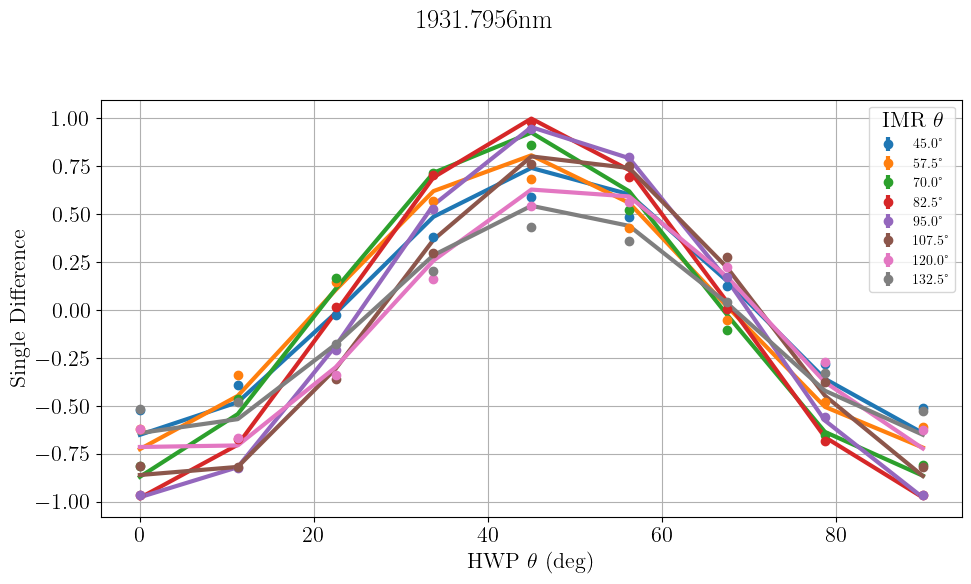

Residuals range: -0.15349213030819098 0.129174694147693


In [2]:
# Make a plot of the mcmc results
# Loading in MCMC fits

offset_imr = -0.27842 # derotator offset
offset_hwp = -2.09738 # HWP offset
offset_cal = -0.79060# calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)

# Load in data
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin15_no_pickoff.csv')
interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")


# Get our model retardances from Joost t Hart physical models

p = [HWP_retardance(wavelength_bins)[15], IMR_retardance(wavelength_bins)[15]]


# Gefine what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities, 'CHARIS')

# Plot the modeled and observed values


plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums,configuration_list, wavelength= wavelength_bins[15], mode='CHARIS',save_path='/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/plots/mcmcbin15.png')

# Print residuals (will be useful later to see if your fit improved at a quick glance)
residuals = interleaved_values[::2] - diffs_sums[::2]
print("Residuals range:", residuals.min(), residuals.max())


In [27]:
np.linspace(45,127.5,12)


array([ 45. ,  52.5,  60. ,  67.5,  75. ,  82.5,  90. ,  97.5, 105. ,
       112.5, 120. , 127.5])

In [4]:
wavelength_bins[12]


1744.3261

Interleaved Values


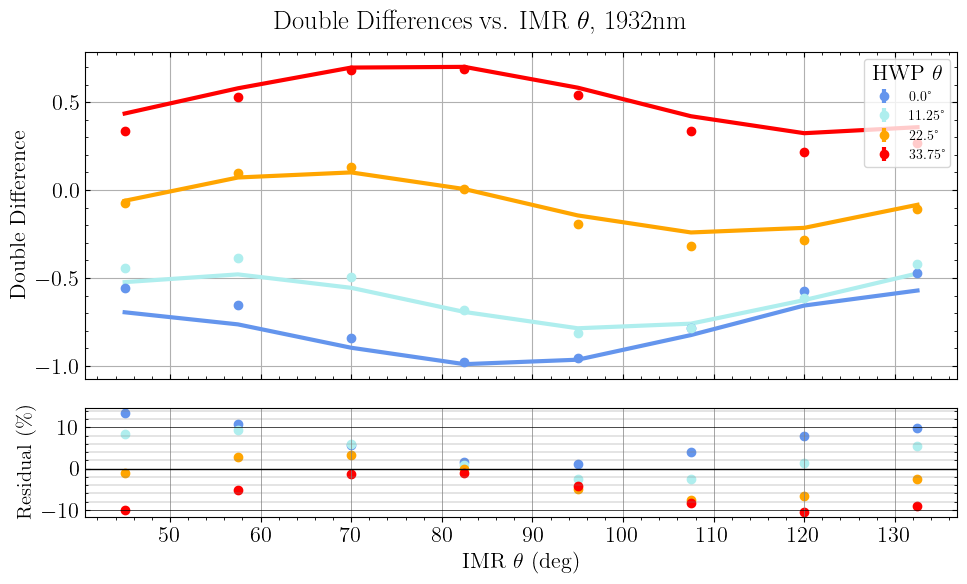

In [2]:
# Make a plot of the mcmc results

offset_imr =-0.13214# derotator offset
offset_hwp = -0.99287 # HWP offset
offset_cal =0.49797# calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "diattenuator_retarder_function",
                "properties": {"epsilon":1,"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)

# Load in data
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin15_no_pickoff.csv')
interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")


# Get our model retardances 
wsio2_ = 1.58689892
wmgf2_ =1.24097736
d_ = 264.6121
p = [HWP_retardance(wavelength_bins,wsio2_,wmgf2_)[15], IMR_retardance(wavelength_bins,d_)[15]]


# Gefine what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities)

# Plot the modeled and observed values


fig_imr, ax_imr,small_ax = plot_data_and_model_x_imr(interleaved_values, interleaved_stds, diffs_sums,configuration_list, hwp_theta_filter=[0,11.25,22.5,33.75],wavelength= wavelength_bins[15], title=r'Double Differences vs. IMR $\theta$, 1932nm')
ax_imr.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  # both major and minor
)
ax_imr.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
# Show minor ticks
ax_imr.minorticks_on()
ax_imr.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',
      # both major and minor
)
small_ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)




# Show minor ticks
small_ax.minorticks_on()
#fig_imr.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/plots/MCMC_vs_imr_1329nm.png', bbox_inches='tight', dpi=600)


# Print residuals (will be useful later to see if your fit improved at a quick glance)
#residuals = interleaved_values[::2] - diffs_sums[::2]
#print("Residuals range:", residuals.min(), residuals.max())


In [81]:
def plot_data_and_model_x_imr2(interleaved_values, interleaved_stds, model, 
    configuration_list, hwp_theta_filter=None, wavelength=None, save_path=None, title=None,
    interleaved_values_2=None, configuration_list_2=None):
    """
    Same as before, but allows overlaying a second dataset as black x's labeled "Pickoff In".
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.ticker import MultipleLocator

    # Extract dd and ds values from primary dataset
    dd_values = interleaved_values[::2]
    ds_values = interleaved_values[1::2]
    dd_stds = interleaved_stds[::2]
    ds_stds = interleaved_stds[1::2]
    dd_model = model[::2]
    ds_model = model[1::2]

    dd_by_theta = {}
    ds_by_theta = {}

    for i, config in enumerate(configuration_list):
        imr_theta = config["image_rotator"]["theta"]
        hwp_theta = config["hwp"]["theta"]

        if hwp_theta_filter is not None and not np.any(np.isclose(hwp_theta, hwp_theta_filter, atol=1e-2)):
            continue

        if hwp_theta not in dd_by_theta:
            dd_by_theta[hwp_theta] = {"imr_theta": [], "values": [], "stds": [], "model": []}
        dd_by_theta[hwp_theta]["imr_theta"].append(imr_theta)
        dd_by_theta[hwp_theta]["values"].append(dd_values[i])
        dd_by_theta[hwp_theta]["stds"].append(dd_stds[i])
        dd_by_theta[hwp_theta]["model"].append(dd_model[i])

        if hwp_theta not in ds_by_theta:
            ds_by_theta[hwp_theta] = {"imr_theta": [], "values": [], "stds": [], "model": []}
        ds_by_theta[hwp_theta]["imr_theta"].append(imr_theta)
        ds_by_theta[hwp_theta]["values"].append(ds_values[i])
        ds_by_theta[hwp_theta]["stds"].append(ds_stds[i])
        ds_by_theta[hwp_theta]["model"].append(ds_model[i])

    fig, axarr = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={"height_ratios": [3, 1]}, sharex=True)
    ax, small_ax = axarr

    hart_cmap = ['cornflowerblue', 'paleturquoise', 'orange', 'red']
    for idx, (theta, d) in enumerate(dd_by_theta.items()):
        color = hart_cmap[idx % len(hart_cmap)]
        err = ax.errorbar(d["imr_theta"], d["values"], color=color, yerr=d["stds"], fmt='o', label=f"{theta}°")
        ax.plot(d["imr_theta"], d["model"], '-', color=color)
        residuals = (np.array(d["values"]) - np.array(d["model"])) * 100
        small_ax.scatter(d["imr_theta"], residuals, color=color)

    # Optional overlay of second dataset (black x's)
    pickoff_label_plotted = False
    if interleaved_values_2 is not None:
        if configuration_list_2 is None:
            configuration_list_2 = configuration_list
        dd_values_2 = interleaved_values_2[::2]
        for i, config in enumerate(configuration_list_2):
            imr_theta = config["image_rotator"]["theta"]
            hwp_theta = config["hwp"]["theta"]
            if hwp_theta_filter is not None and not np.any(np.isclose(hwp_theta, hwp_theta_filter, atol=1e-2)):
                continue
            if not pickoff_label_plotted:
                ax.scatter(imr_theta, dd_values_2[i], marker='x', color='black', linewidths=1.5, label="Pickoff In",zorder=5)
                pickoff_label_plotted = True
            else:
                ax.scatter(imr_theta, dd_values_2[i], marker='x', color='black', linewidths=1.5,zorder=5)

    # Final plot styling
    small_ax.axhline(0, color='black', linewidth=1)
    small_ax.grid(which='major', axis='y', linestyle='-', linewidth=0.5, color='black')
    small_ax.grid(which='minor', axis='y', linestyle='-', linewidth=0.3, color='gray')
    small_ax.set_xlabel(r"IMR $\theta$ (deg)")
    small_ax.set_ylabel(r"Residual ($\%$)", fontsize=15)
    small_ax.xaxis.set_major_locator(MultipleLocator(10))
    small_ax.tick_params(axis='y', which='minor', labelleft=False)

    ax.set_ylabel("Single Difference")
    ax.legend(title=r"HWP $\theta$", fontsize=10, loc='upper right')
    ax.grid()

    if wavelength is not None and title is None:
        fig.suptitle(f"{wavelength}nm")
    if title:
        fig.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')

    return fig, ax, small_ax


In [2]:
filepath2 = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_pickoff/charis_cube_info_bin4_with_pickoff.csv'
interleaved_values2,interleaved_stds2,configuration_list2 = read_csv(filepath2)
fig_imr2,ax_imr2,small_ax2 = plot_data_and_model_x_imr2(interleaved_values,interleaved_stds,diffs_sums,configuration_list,hwp_theta_filter=[0,11.25,22.5,33.75],wavelength= wavelength_bins[15],title='',interleaved_values_2=interleaved_values2,configuration_list_2=configuration_list2)
ax_imr2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  # both major and minor
)
ax_imr2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
# Show minor ticks
ax_imr2.minorticks_on()
ax_imr2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',
      # both major and minor
)
small_ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)




# Show minor ticks
small_ax2.minorticks_on()
fig_imr2.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_singlediff_vs_imr1932', bbox_inches='tight', dpi=600)


NameError: name 'interleaved_values' is not defined

In [26]:
def first_two_sigfigs(x):
    x = abs(x)
    while x >= 100:
        x //= 10
    while x < 10:
        x *= 10
    return int(x)
def bin_by_step(x, step=0.03):
    """
    Bins x to the nearest multiple of `step`, using centered bins.
    This prevents rounding artifacts and ensures consistency.
    """
    return round(x / step) * step

def write_fits_info_to_csv_hart(cube_directory_path, raw_cube_path, output_csv_path, wavelength_bin):
    """Write filepath, D_IMRANG (derotator angle), RET-ANG1 (HWP angle), 
    single sum, single difference, LCOUNTS, RCOUNTS, difference std,
    sum std, and wavelength values for a wavelength bin from each fits cube in the directory.
    Excludes redundant frames.

    FITS parameters are extracted from raw files, while single sum and difference are calculated using the
    fits cube data and the defined rectangular apertures.
    If the necessary header keywords are not present, the values will be set to NaN.

    Note - This function assumes that the raw and extracted cubes have the same number in the filepath. If
    you processed your cubes in the CHARIS DPP, this is not the case. 
    
    Parameters:
    -----------
    fits_directory_path : str or Path
        Path to the directory containing CHARIS fits cubes.
        
    raw_cube_path : str or Path
        Path to the directory containing the matching raw CHARIS FITS files.

    output_csv_path : str or Path
        Path where the output csv will be created.

    wavelength_bin : int
        Index of the wavelength bin to analyze (0-based).

    Returns:
    --------
    None
    """
    # check for valid file paths

    cube_directory_path = Path(cube_directory_path)
    raw_cube_path = Path(raw_cube_path)
    output_csv_path = Path(output_csv_path)

    if not cube_directory_path.is_dir():
        raise NotADirectoryError(f"Directory not found: {cube_directory_path}")
    if output_csv_path.suffix != '.csv':
        raise ValueError(f"Output path must be a CSV file, got {output_csv_path}")
    if not raw_cube_path.is_dir():
        raise NotADirectoryError(f"Raw cube directory does not exist: {raw_cube_path}")
    if wavelength_bin > 21:
        raise ValueError(f"This function is currently only compatible with lowres mode, with 22 wavelength bins.")
    
    # prepare output csv file

    output_csv_path = Path(output_csv_path)
    with open(output_csv_path, 'w') as f:
        f.write("filepath,D_IMRANG,RET-ANG1,single_sum,norm_single_diff,LCOUNTS,RCOUNTS,sum_std,diff_std,wavelength_bin\n")

        # iterate over all fits files in the directory
        previous_diff=previous_sum=None
        for fits_file in sorted(cube_directory_path.glob('*.fits')):
            try:

                # check if corresponding raw fits file exists
                 
                match = re.search(r"(\d{8})", fits_file.name)
                if not match:
                    raise ValueError(f"Could not extract 8-digit ID from filename {fits_file.name}")
                fits_id = match.group(1)
                raw_candidates = list(raw_cube_path.glob(f"*{fits_id}*.fits"))
                if not raw_candidates:
                    raise FileNotFoundError(f"No raw FITS file found for ID {fits_id}")
                raw_fits = raw_candidates[0]
                
                with fits.open(raw_fits) as hdul_raw:
                    raw_header = hdul_raw[0].header
                    d_imrang = raw_header.get("D_IMRANG", np.nan)
                    ret_ang1 = raw_header.get("RET-ANG1", np.nan)

                # round d_imrang to nearest 0.5
               
                d_imrang = (np.round(d_imrang * 2) / 2)

                # calculate single sum and normalized single difference

                single_sum, norm_single_diff, LCOUNTS, RCOUNTS, sum_std, diff_std = single_sum_and_diff(fits_file, wavelength_bin)
                rounded_norm_single_diff = bin_by_step(norm_single_diff)
                
                rounded_single_sum = first_two_sigfigs(single_sum)
                
                # wavelength bins for lowres mode

                bins = wavelength_bins
                
                # write to csv file
                # if there is no previous file, write the first
                if previous_diff is None and previous_sum is None:
                    f.write(f"{fits_file}, {d_imrang}, {ret_ang1}, {single_sum}, {norm_single_diff}, {LCOUNTS}, {RCOUNTS}, {sum_std}, {diff_std}, {bins[wavelength_bin]}\n")
                    print(f"First CSV file written to {output_csv_path}")
                    previous_diff = rounded_norm_single_diff
                    previous_sum = rounded_single_sum
                    
                # add a tag if the sums and diffs are similar to the previous one
                else:
                    if rounded_norm_single_diff==previous_diff and rounded_single_sum==previous_sum:
                        tagged_fits_file = fits_file.with_name(f'{fits_file.stem}_DUP{fits_file.suffix}')
                        f.write(f"{tagged_fits_file}, {d_imrang}, {ret_ang1}, {single_sum}, {norm_single_diff}, {LCOUNTS}, {RCOUNTS}, {sum_std}, {diff_std}, {bins[wavelength_bin]}\n")
                        print(f"Similar differences detected and tagged at {output_csv_path}")
                        previous_diff = rounded_norm_single_diff
                        previous_sum = rounded_single_sum                    
                    else:
                        f.write(f"{fits_file}, {d_imrang}, {ret_ang1}, {single_sum}, {norm_single_diff}, {LCOUNTS}, {RCOUNTS}, {sum_std}, {diff_std}, {bins[wavelength_bin]}\n")
                        print(f"CSV file written to {output_csv_path}")
                        previous_diff = rounded_norm_single_diff
                        previous_sum = rounded_single_sum

            except Exception as e:
                print(f"Error processing {fits_file}: {e}")
    

In [38]:
def process_duplicates(csv_path):
    """Takes the mean of all tagged duplicates single differences
    in the Hart csvs.

    Parameters
    ----------
    csv_path: str or Path
        Path to the csv.
    
    Returns
    -------
    None
        Alters the csv to have one file per duplicate with averaged differences.
    """
    # convert to a path

    csv_path = Path(csv_path)

    # load to dataframe

    df = pd.read_csv(csv_path)
    files = np.array(df["filepath"])
    single_differences = np.array(df["norm_single_diff"])
    tagged_file_idx = []
    # set up boolean mask if DUP tag is there
    for idx, file in enumerate(files):
        match = re.search('DUP',file)
        if match is not None: 
            print(f'Duplicate found: {file}.')
            if not tagged_file_idx:
                tagged_file_idx.append(idx-1)
                tagged_file_idx.append(idx)
            else:
                tagged_file_idx.append(idx)
        if match is None and tagged_file_idx:
            # get single difference avg
            avg_single_diff = np.median(single_differences[tagged_file_idx])
            # write to df
            df.loc[tagged_file_idx[0], "norm_single_diff"] = avg_single_diff
            print(f"Average of duplicate single differences stored at {files[tagged_file_idx[0]]}")
            # only keep the averaged single difference
            rows_todelete = tagged_file_idx[1:]
            df = df.drop(index=rows_todelete)
            tagged_file_idx = []
    df.to_csv(csv_path)



# note -fix to work with end of csvs maybe?





    


In [39]:
for bin in range(4,5):
    write_fits_info_to_csv_hart('/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes','/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/raw/2020-02-18',f'/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin{bin}.csv',bin)

First CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin4.csv
Error processing /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059592_cube.fits: No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin4.csv
Error processing /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059594_cube.fits: No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Similar differences detected and tagged at /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin4.csv
Error processing /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059596_cube.fits: No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Similar differences 

In [40]:
process_duplicates('/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin4.csv')


Duplicate found: /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059595_cube_DUP.fits.
Duplicate found: /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059597_cube_DUP.fits.
Average of duplicate single differences stored at /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059593_cube.fits
Duplicate found: /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059600_cube_DUP.fits.
Duplicate found: /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059602_cube_DUP.fits.
Average of duplicate single differences stored at /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059599_cube.fits
Duplicate found: /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059606_cube_DUP.fits.
Duplicate found: /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059608_cube_DUP.fits.
Average of duplicate single differences stored at /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059604_cube.fits
Duplicate found: /Users/thomasmcintosh/Desk

In [23]:
def fix_hwp_angles_hart(csv_file_path, nderotator=10):
    '''Take corrupted HWP angles and replace them with assumed values
    in a new csv titled {old_title}_fixed. Works with Joost t Hart 2021 data.

    Parameters:
    -----------
    csv_file_path : str or Path
        Path to the specified CSV file containing the corrupted HWP angles.
    
    nderotator : int
        Number of derotator angles (assumed to be 8).
    Returns:
    --------
    None
    '''
    # check if csv_file_path is a valid file path

    csv_file_path = Path(csv_file_path)
    if not csv_file_path.is_file():
        raise FileNotFoundError(f"File not found: {csv_file_path}")
    
    # read csv file into pandas dataframe

    df = pd.read_csv(csv_file_path)

    # check if 'RET-ANG1' column is present

    if 'RET-ANG1' not in df.columns:
        raise ValueError("Column 'RET-ANG1' is missing from the CSV file.")
    
    hwp_angles = np.array([45,56.25,67.5,78.75,0,11.25,22.5,33.75])
    hwp_angles_assumed = np.tile(hwp_angles, nderotator)  # repeat for n derotator angles
    df["RET-ANG1"] = hwp_angles_assumed # replace 'RET-ANG1' with assumed values
    # save to new csv file with '_fixed' suffix
    
    fixed_csv_path = csv_file_path.with_name(csv_file_path.stem + '_fixed.csv')
    df.to_csv(fixed_csv_path, index=False)
  

    print(f"Fixed HWP angles saved to {fixed_csv_path}")


In [41]:
fix_hwp_angles_hart('/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin4.csv')


Fixed HWP angles saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin4_fixed.csv


In [24]:
for bin in range(4,5):
    fix_hwp_angles_hart(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs/bin{bin}.csv')

Fixed HWP angles saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs/bin4_fixed.csv


In [38]:
print(wavelength_bins[4])

1328.6331


In [93]:
def plot_data_and_model_x_imr_webplot(interleaved_values, interleaved_stds, model, 
    configuration_list, hwp_theta_filter=None, wavelength=None, save_path = None,title=None):
    """
    Plots single differences vs imr angle for some amount of HWP angles. Similar to figure 6 in
    Joost t Hart 2021.

    Parameters
    ----------
    interleaved_values : np.ndarray
        Interleaved array of observed double difference and double sum values.
        Expected format: [dd1, ds1, dd2, ds2, ...]. In CHARIS mode use
        single differences and sums.

    interleaved_stds : np.ndarray
        Interleaved array of standard deviations corresponding to the observed values.

    model : np.ndarray
        Interleaved array of model-predicted double difference and double sum values.
        If charis use single differences and sums. 

    configuration_list : list of dict
        List of system configurations (one for each measurement), where each dictionary 
        contains component settings like HWP and image rotator angles.

    hwp_theta_filter : float, optional
        If provided, only measurements with this hwp angle will be plotted.

    wavelength : str or int, optional
        Wavelength (e.g., 670 or "670") to display as a centered title with "nm" units 
        (e.g., "670nm").
    title: str, optional
        Optional title

    Returns
    -------
    fig, ax, small_ax
    """
    # Calculate double differences and sums from interleaved single differences if in VAMPIRES mode 
    

    # Extract double differences and double sums
    dd_values = interleaved_values[::2]
    ds_values = interleaved_values[1::2]
    dd_stds = interleaved_stds[::2]
    ds_stds = interleaved_stds[1::2]
    dd_model = model[::2]
    ds_model = model[1::2]

    # Group by hwp theta
    dd_by_theta = {}
    ds_by_theta = {}
   
    
    for i, config in enumerate(configuration_list):
        imr_theta = config["image_rotator"]["theta"]
        hwp_theta = config["hwp"]["theta"]

        if hwp_theta_filter is not None and not np.any(np.isclose(hwp_theta, hwp_theta_filter, atol=1e-2)):
         continue

        if hwp_theta not in dd_by_theta:
            dd_by_theta[hwp_theta] = {"imr_theta": [], "values": [], "stds": [], "model": []}
        dd_by_theta[hwp_theta]["imr_theta"].append(imr_theta)
        dd_by_theta[hwp_theta]["values"].append(dd_values[i])
        dd_by_theta[hwp_theta]["stds"].append(dd_stds[i])
        dd_by_theta[hwp_theta]["model"].append(dd_model[i])

        if hwp_theta not in ds_by_theta:
            ds_by_theta[hwp_theta] = {"imr_theta": [], "values": [], "stds": [], "model": []}
        ds_by_theta[hwp_theta]["imr_theta"].append(imr_theta)
        ds_by_theta[hwp_theta]["values"].append(ds_values[i])
        ds_by_theta[hwp_theta]["stds"].append(ds_stds[i])
        ds_by_theta[hwp_theta]["model"].append(ds_model[i])

    imrangles = [45,52.5,60,67.5,75,82.5,90,97.5,105,112.5]
    df0 = pd.read_csv('/Users/thomasmcintosh/Downloads/0_HWP.csv',header=None)
    df1125= pd.read_csv('/Users/thomasmcintosh/Downloads/1125_HWP.csv',header=None)
    df225 = pd.read_csv('/Users/thomasmcintosh/Downloads/225_HWP.csv',header=None)
    df3375 = pd.read_csv('/Users/thomasmcintosh/Downloads/3375_HWP.csv',header=None)
    
    num_plots = 1
    sizex=10
    fig, axarr = plt.subplots(
    3, 1, 
    figsize=(sizex, 6), 
    gridspec_kw={"height_ratios": [3, 1,1]}, 
    sharex=True
    )

    ax = axarr[0]
    small_ax = axarr[1]
    small_ax_2 = axarr[2]
    webplot = [df0[1],df1125[1],df225[1],df3375[1]]
    # Double Difference plot
    
    for idx, (theta, d) in enumerate(dd_by_theta.items()):
        hart_cmap = ['cornflowerblue','paleturquoise','orange','red']
        color=hart_cmap[idx]
        err = ax.errorbar(d["imr_theta"], d["values"], color=color,yerr=d["stds"], fmt='o', label=f"{theta}°")
        #color = err[0].get_color
        ax.plot(d["imr_theta"], d["model"], '-', color=color)
        residuals =  (np.array(d["values"]) - np.array(d["model"]))*100
        small_ax.scatter(d['imr_theta'],residuals,color=color)
        residuals2 = (np.array(-webplot[idx])-np.array(d["model"]))*100
        small_ax_2.scatter(imrangles,residuals2)
        print(d["imr_theta"])
        print(d['values'])
    small_ax.axhline(0, color='black', linewidth=1)
    small_ax.grid(which='major', axis='y', linestyle='-', linewidth=0.5, color='black')
    small_ax.grid(which='minor',axis='y', linestyle='-', linewidth=0.3, color='gray')
    small_ax.set_xlabel(r"IMR $\theta$ (deg)")
    small_ax.set_ylabel(r"Residual ($\%$)", fontsize = 10)
    small_ax_2.axhline(0, color='black', linewidth=1)
    small_ax_2.grid(which='major', axis='y', linestyle='-', linewidth=0.5, color='black')
    small_ax_2.grid(which='minor',axis='y', linestyle='-', linewidth=0.3, color='gray')
    small_ax_2.set_xlabel(r"IMR $\theta$ (deg)")
    small_ax_2.set_ylabel(r"WebPlot Residual ($\%$)", fontsize = 10)
    
    #small_ax.yaxis.set_minor_locator(MultipleLocator(1))
    small_ax.xaxis.set_major_locator(MultipleLocator(10))
    small_ax.grid(which='major', axis='x', linestyle='-', linewidth=0.5, color='gray')
    small_ax.tick_params(axis='y', which='minor', labelleft=False)
    small_ax_2.xaxis.set_major_locator(MultipleLocator(10))
    small_ax_2.grid(which='major', axis='x', linestyle='-', linewidth=0.5, color='gray')
    small_ax_2.tick_params(axis='y', which='minor', labelleft=False)
    
    ax.scatter(imrangles,-df0[1],marker='x',color='black',label='Web Plot Digitized')
    ax.scatter(imrangles,-df1125[1],marker='x',color='black')
    ax.scatter(imrangles,-df225[1],marker='x',color='black')
    ax.scatter(imrangles,-df3375[1],marker='x',color='black')
    

    
    ax.legend()
    ax.set_ylabel("Single Difference")
    ax.legend(title=r"HWP $\theta$", fontsize=10, loc='upper right')
    ax.grid()

    # Set a suptitle if wavelength is provided
    if wavelength is not None and title is None:
        fig.suptitle(f"{wavelength}nm")
        ax.xaxis.set_major_locator(MultipleLocator(10))    
        ax.xaxis.set_minor_locator(MultipleLocator(1)) 
    plt.tight_layout(rect=[0, 0, 1, 0.95])  #

    if title:
        fig.suptitle(title)

    if save_path != None:
        plt.savefig(save_path,dpi=600, bbox_inches='tight')


    return fig, ax,small_ax

Interleaved Values
[45.0, 52.5, 60.0, 67.5, 75.0, 82.5, 90.0, 97.5, 105.0, 112.5]
[-0.019239821682751, 0.4806775786556497, 0.8563412748525258, 0.9828741242866614, 0.8136730593699797, 0.4109919292032228, -0.090797865973354, -0.5581190098136622, -0.8810307093478399, -0.9872678893454992]
[45.0, 52.5, 60.0, 67.5, 75.0, 82.5, 90.0, 97.5, 105.0, 112.5]
[-0.6922546996559933, -0.262933442171958, 0.2417626622039635, 0.6980456953943083, 0.9626013803108948, 0.9388742691043814, 0.6392683347256312, 0.1703640560806829, -0.3299325962659826, -0.73929858065037]
[45.0, 52.5, 60.0, 67.5, 75.0, 82.5, 90.0, 97.5, 105.0, 112.5]
[-0.9666534066415428, -0.8315274923054609, -0.4904799150746342, -0.016019129518986, 0.4818150925593947, 0.8592045163487637, 0.9848737952161012, 0.8179545677906779, 0.4218559075524954, -0.0797062106296229]
[45.0, 52.5, 60.0, 67.5, 75.0, 82.5, 90.0, 97.5, 105.0, 112.5]
[-0.7247185970450561, -0.9386201422833432, -0.9254930598946624, -0.6869026806889394, -0.2713780717158864, 0.2313675298

,0,1
0,45.2,0.984375
1,45.2,0.718750
2,45.2,-0.031250
3,44.8,0.703125


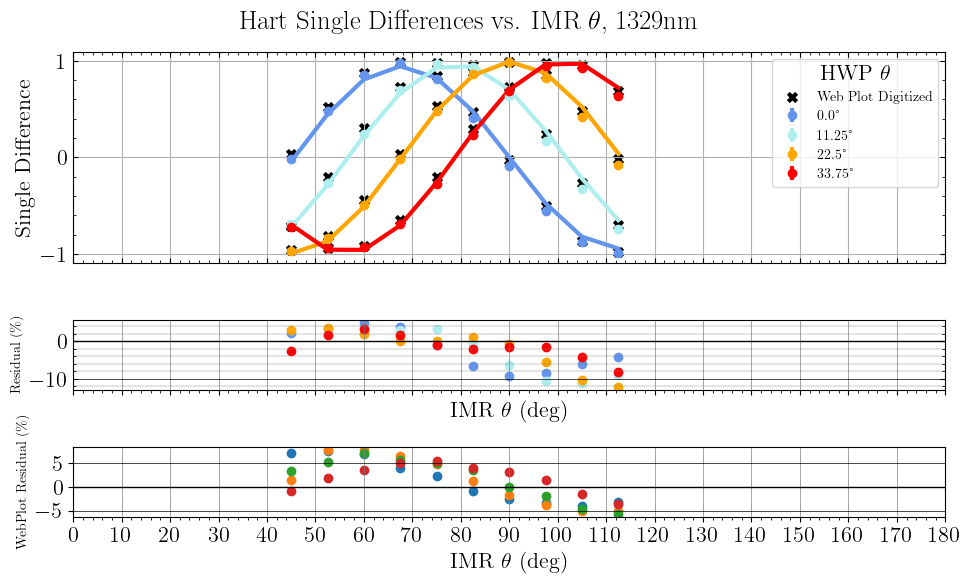

In [95]:
# reproduce Hart data

offset_imr = -0.0118 # derotator offset
offset_hwp = -0.002 # HWP offset
offset_cal = -0.035 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "diattenuator_retarder_function",
                "properties": {"theta":-45,"epsilon":1,"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)

# Load in data
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin4_fixed.csv')
interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")


# Get our model retardances from Joost t Hart physical models
wsio2_ = 1.623
wmgf2_ = 1.268
d_ = 262.56
p = [HWP_retardance(wavelength_bins,wsio2_,wmgf2_)[4], IMR_retardance(wavelength_bins,d_)[4]]


# Gefine what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities, 'CHARIS')

# Plot the modeled and observed values


fig_imr, ax_imr,small_ax = plot_data_and_model_x_imr_webplot(interleaved_values, interleaved_stds, diffs_sums,configuration_list, hwp_theta_filter=[0,11.25,22.5,33.75],wavelength= wavelength_bins[4], title=r'Hart Single Differences vs. IMR $\theta$, 1329nm')
ax_imr.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  # both major and minor
)
ax_imr.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
# Show minor ticks
ax_imr.minorticks_on()
ax_imr.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',
      # both major and minor
)
small_ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)

small_ax.set_xlim(0,180)

# Show minor ticks
small_ax.minorticks_on()
#fig_imr.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/plots/vs_imr_1575nm.png', bbox_inches='tight', dpi=600)

df45 = pd.read_csv('/Users/thomasmcintosh/Downloads/45.csv',header=None)
df82= pd.read_csv('/Users/thomasmcintosh/Downloads/82.5.csv',header=None)
df105 = pd.read_csv('/Users/thomasmcintosh/Downloads/105.csv',header=None)
df112 = pd.read_csv('/Users/thomasmcintosh/Downloads/112.5.csv',header=None)


# Print residuals (will be useful later to see if your fit improved at a quick glance)
residuals = interleaved_values[::2] - diffs_sums[::2]
print("Residuals range:", residuals.min(), residuals.max())
#ax_imr.invert_yaxis()
df45